In [205]:
'''
基于CNN-LSTM混合模型对预测类问题进行研究
这是第一篇
基于CNN-LSTM混合模型对股票增长进行预测
Research on Prediction Problems Based on CNN-LSTM Hybrid Model
This is the first article
Predicting Stock Growth Based on CNN-LSTM Hybrid Model
Quoted from:
https://aistudio.baidu.com/projectdetail/4127001
'''

'\n基于CNN-LSTM混合模型对预测类问题进行研究\n这是第一篇\n基于CNN-LSTM混合模型对股票增长进行预测\nResearch on Prediction Problems Based on CNN-LSTM Hybrid Model\nThis is the first article\nPredicting Stock Growth Based on CNN-LSTM Hybrid Model\nQuoted from:\nhttps://aistudio.baidu.com/projectdetail/4127001\n'

In [206]:
#导包
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import Sequential,Module,Conv2d,MaxPool2d,Linear,LSTM,ReLU,Dropout2d
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from model import *

In [207]:
#数据获取
data = pd.read_csv("data.csv")
print(data)

           date   open   high  close    low      volume
0    2019-11-27  15.64  15.64  15.47  15.39   476170.00
1    2019-11-28  15.47  15.54  15.49  15.44   378016.53
2    2019-11-29  15.54  15.55  15.29  15.18   653866.94
3    2019-12-02  15.35  15.43  15.36  15.23   553877.38
4    2019-12-03  15.30  15.46  15.45  15.21   455418.03
..          ...    ...    ...    ...    ...         ...
601  2022-05-23  15.07  15.07  14.83  14.76   647725.94
602  2022-05-24  14.87  14.87  14.40  14.40   933557.06
603  2022-05-25  14.43  14.49  14.39  14.30   603228.25
604  2022-05-26  14.41  14.43  14.19  14.07  1011317.62
605  2022-05-27  14.29  14.35  14.18  14.11   723066.75

[606 rows x 6 columns]


In [208]:
# 窗口划分
def split_windows(data, size):
    X = []
    Y = []
    # X作为数据，Y作为标签
    # 滑动窗口，步长为1，构造窗口化数据，每一个窗口的数据标签是窗口末端的close值（收盘价格）
    for i in range(len(data) - size):
        X.append(data[i:i+size, :])
        Y.append(data[i+size, 2])
    return np.array(X), np.array(Y)

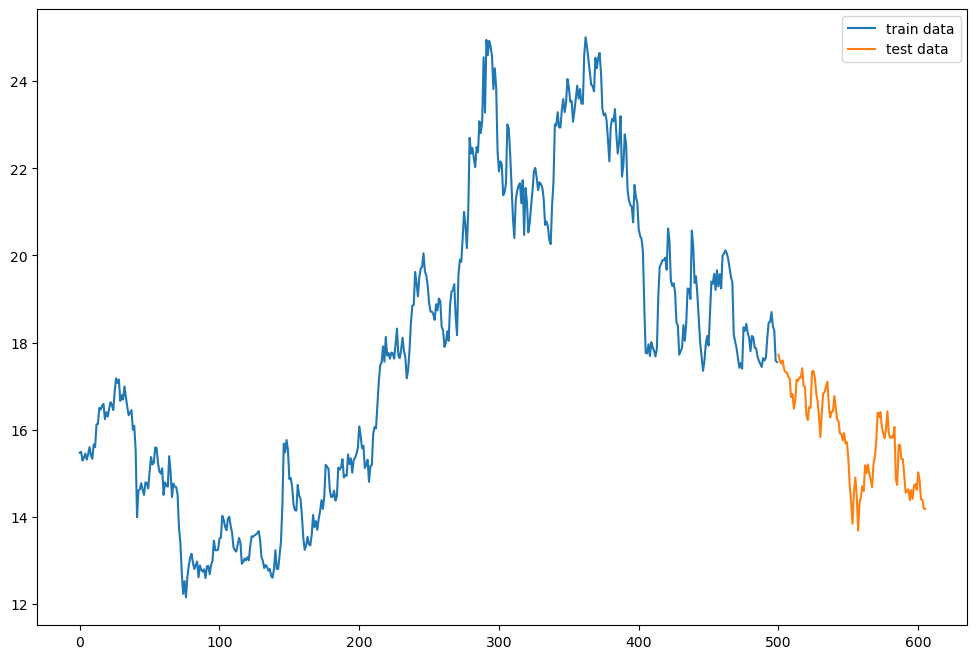

In [209]:
#使用前500个数据用于训练，剩余数据用于预测
df = pd.read_csv('data.csv', usecols=['open', 'high', 'close', 'low', 'volume'])
all_data = df.values
train_len = 500
train_data = all_data[:train_len, :]
test_data = all_data[train_len:, :]
plt.figure(figsize=(12, 8))
# 数据可视化
plt.plot(np.arange(train_data.shape[0]), train_data[:, 2], label='train data')
plt.plot(np.arange(train_data.shape[0], train_data.shape[0] + test_data.shape[0]), test_data[:, 2], label='test data')
plt.legend()

In [210]:
#数据归一化处理
# normalizatioin processing
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
# 使用训练集的最值对测试集归一化，保证训练集和测试集的分布一致性
scaled_test_data = scaler.transform(test_data)
# 训练集测试集划分
window_size = 7
train_X, train_Y = split_windows(scaled_train_data, size=window_size)
test_X, test_Y = split_windows(scaled_test_data, size=window_size)
print('train shape', train_X.shape, train_Y.shape)
print('test shape', test_X.shape, test_Y.shape)
# print(train_Y)

train shape (493, 7, 5) (493,)
test shape (99, 7, 5) (99,)


In [211]:
# #模型搭建
# '''
# train_X大小为(493,7,5)可以视为493张7*5的图像,因而可以用CNN(卷积神经网络)处理
# '''
# window_size = 7
# fea_num = 5
# batch_size = 32
# class CNN_LSTM(nn.Module):
#     '''
#     This is a new model
#     window_size:
#     fea_num:

#     '''
#     def __init__(self,window_size,fea_num):
#         super().__init__()
#         self.window_size = window_size
#         self.fea_num = fea_num
#         self.model1 = Sequential(
#             Conv2d(in_channels = 1,out_channels = 64,kernel_size = 3,stride = 1,padding = 1),
#             ReLU(),
#             MaxPool2d(kernel_size = 3,stride = 1,padding = 1),
#             Dropout2d(0.3),
#         )
#         self.lstm1 = LSTM(input_size = 64*fea_num, hidden_size = 128, num_layers = 1)
#         self.lstm2 = LSTM(input_size = 128, hidden_size = 64, num_layers = 1)
#         self.linear1 = Linear(in_features = 64, out_features = 32)
#         self.relu = ReLU()
#         self.linear2 = Linear(in_features = 32, out_features = 1)
#     def forward(self,x):
#         x = x.reshape([x.shape[0],1,self.window_size,self.fea_num]) 
#         x = self.model1(x)

#         x = x.reshape([x.shape[0], self.window_size, -1])
#         x,(h,c) = self.lstm1(x)
#         x,(h,c) = self.lstm2(x)
#         x = x[:,-1,:]
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.linear2(x)
#         return x
# mymodel = CNN_LSTM(window_size,fea_num)
# # test1 = torch.ones((99,7,5))
# # print(test1.shape)
# # print((mymodel(test1.float())).shape)


In [212]:
# 调用模型
mymodel = CNN_LSTM(window_size,fea_num)

In [213]:
#定义参数
lr = 0.17
batch_size = 32
EPOCH = 1500
#优化器
optimizer = torch.optim.SGD(mymodel.parameters(),lr=lr)
#动态学习率调整器
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size =50 , gamma=0.1, last_epoch=-1)
#损失函数
loss_fn = nn.MSELoss()


In [214]:
# 分批处理数据
def process(data, bs):
    l = len(data)
    tmp = []
    for i in range(0, l, bs):
        if i + bs > l:
            tmp.append(data[i:].tolist())
        else:
            tmp.append(data[i:i+bs].tolist())
    tmp = np.array(tmp,dtype=object)
    return tmp

In [215]:
# 处理数据集
# 按批处理 train_X 原来大小为（493，7，5） 现在分批打包处理为（16，）
train_X = process(train_X, 32)
train_Y = process(train_Y, 32)
print(train_X.shape,train_Y.shape)

(16,) (16,)


In [216]:
# 模式选择
mode = 'TRAIN'

In [217]:
# 模型训练
if mode == 'TRAIN':
    for epoch in range(EPOCH):
        mymodel.train()
        loss_train = 0
        for batch_id, data in enumerate(train_X):
            label = train_Y[batch_id]
            data = torch.tensor(data)
            label = torch.tensor(label)
            label = label.reshape([label.shape[0],1])
            y = mymodel(data)
            optimizer.zero_grad()
            loss = loss_fn(y,label)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        print("[TRAIN] =========epoch : {},  loss  {:.4f}======== ".format(epoch+1,loss_train))
        # scheduler.step()
    torch.save(mymodel,'work/model.pth')
    # torch.save(scheduler,'work/scheduler.pth')


[TRAIN] =========epoch : 1,  loss  0.6494======== 
[TRAIN] =========epoch : 2,  loss  0.6207======== 
[TRAIN] =========epoch : 3,  loss  0.6155======== 
[TRAIN] =========epoch : 4,  loss  0.6065======== 
[TRAIN] =========epoch : 5,  loss  0.5667======== 
[TRAIN] =========epoch : 6,  loss  0.5448======== 
[TRAIN] =========epoch : 7,  loss  0.5240======== 
[TRAIN] =========epoch : 8,  loss  0.4821======== 
[TRAIN] =========epoch : 9,  loss  0.4646======== 
[TRAIN] =========epoch : 10,  loss  0.4253======== 
[TRAIN] =========epoch : 11,  loss  0.3680======== 
[TRAIN] =========epoch : 12,  loss  0.3676======== 
[TRAIN] =========epoch : 13,  loss  0.3498======== 
[TRAIN] =========epoch : 14,  loss  0.3739======== 
[TRAIN] =========epoch : 15,  loss  0.3836======== 
[TRAIN] =========epoch : 16,  loss  0.3224======== 
[TRAIN] =========epoch : 17,  loss  0.3057======== 
[TRAIN] =========epoch : 18,  loss  0.2898======== 
[TRAIN] =========epoch : 19,  loss  0.2874======== 
[TRAIN] =========epoc